<h1 style="text-align: center;">Best MLP model performance on a new dataset</h1>

## 1. LSTM Enc-Dec with attention

In [65]:
# =========================================
# 1. Imports
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Model
from keras.layers import (
    Input, LSTM, Dense, Dropout,
    Attention, Concatenate, TimeDistributed
)
from keras.optimizers import Adam
import tensorflow as tf

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
# =========================================
# 2. Load data from CSV
# =========================================
csv_path = "MicrosoftStock.csv"

df = pd.read_csv(
    csv_path,
    parse_dates=["date"],   # Parse the date column
    index_col="date"        # Set it as index
)

# Drop the old numeric 'index' column if present
if "index" in df.columns:
    df = df.drop(columns=["index"])

# Sort in case something is out of order
df = df.sort_index()

# Use only close column
data = df[["close"]].copy()
data.dropna(inplace=True)

print("Data head:")
print(data.head())
print("Index type:", type(data.index))

Data head:
            close
date             
2013-02-08  27.55
2013-02-11  27.86
2013-02-12  27.88
2013-02-13  28.03
2013-02-14  28.04
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [69]:
# =========================================
# 3. Scaling
# =========================================
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(data.values)   # Shape: (N, 1)

In [71]:
# =========================================
# 4. Build encoder/decoder sequences
# =========================================
# n_past   = number of past days used as encoder input
# n_future = length of decoder (here 1-day-ahead forecasting)
n_past = 60
n_future = 1   # One-step ahead, but still use encoder-decoder structure

encoder_input_data = []
decoder_input_data = []
decoder_target_data = []

# For each time step t >= n_past we create:
# - encoder input  : prices[t-60 : t]
# - decoder input  : price[t-1] (last known value)
# - decoder target : price[t] (next value to predict)
for t in range(n_past, len(scaled_values)):
    enc_seq = scaled_values[t-n_past:t, 0]     # (60,)
    dec_in_seq = scaled_values[t-1:t, 0]       # (1,)
    dec_target_seq = scaled_values[t:t+1, 0]   # (1,)

    encoder_input_data.append(enc_seq)
    decoder_input_data.append(dec_in_seq)
    decoder_target_data.append(dec_target_seq)

encoder_input_data = np.array(encoder_input_data)     # (samples, n_past)
decoder_input_data = np.array(decoder_input_data)     # (samples, n_future)
decoder_target_data = np.array(decoder_target_data)   # (samples, n_future)

# Add feature dimension -> (samples, timesteps, features)
encoder_input_data = np.expand_dims(encoder_input_data, -1)     # (samples, 60, 1)
decoder_input_data = np.expand_dims(decoder_input_data, -1)     # (samples, 1, 1)
decoder_target_data = np.expand_dims(decoder_target_data, -1)   # (samples, 1, 1)

print("Encoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)

Encoder input shape: (1199, 60, 1)
Decoder input shape: (1199, 1, 1)
Decoder target shape: (1199, 1, 1)


In [73]:
# =========================================
# 5. Train / Test split
# =========================================
train_size = int(len(encoder_input_data) * 0.8)

enc_in_train = encoder_input_data[:train_size]
enc_in_test  = encoder_input_data[train_size:]

dec_in_train = decoder_input_data[:train_size]
dec_in_test  = decoder_input_data[train_size:]

dec_tar_train = decoder_target_data[:train_size]
dec_tar_test  = decoder_target_data[train_size:]

print("Train samples:", enc_in_train.shape[0])
print("Test samples :", enc_in_test.shape[0])

Train samples: 959
Test samples : 240


In [75]:
# =========================================
# 6. Encoder–Decoder LSTM with Attention
# =========================================

# ----- Encoder -----
# Input shape: (n_past, 1)
encoder_inputs = Input(shape=(n_past, 1), name="encoder_inputs")

# LSTM returns full sequence and final states (h, c)
encoder_lstm = LSTM(   # Nb parameters: just the normal LSTM
    units=64,
    return_sequences=True,
    return_state=True,
    name="encoder_lstm"
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# ----- Decoder -----
# Decoder input shape: (n_future, 1) -> here (1, 1)
decoder_inputs = Input(shape=(n_future, 1), name="decoder_inputs")

# Decoder LSTM uses encoder final states as initial state
decoder_lstm = LSTM(
    units=64,
    return_sequences=True,
    return_state=True,
    name="decoder_lstm"
)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs,
    initial_state=[state_h, state_c]
)

# ----- Attention -----
# Queries: decoder_outputs  (shape: batch, n_future, 64)
# Keys & Values: encoder_outputs (shape: batch, n_past, 64)
attn_layer = Attention(name="attention_layer")   # No extra parameters because Q = h_decoder and K = V = h_encoder (I need MultiHeadAttention)
attn_out = attn_layer([decoder_outputs, encoder_outputs])   # Context vectors

# Concatenate decoder LSTM outputs with attention context
decoder_concat_input = Concatenate(axis=-1, name="concat_layer")(
    [decoder_outputs, attn_out]
)   # Shape: (batch, n_future, 64 + 64)

# ----- Dense layers (time-distributed) -----
time_dense = TimeDistributed(   # Nb parameters: 128 * (64 + 64) + 128 biases = 16512
    Dense(128, activation="relu"),
    name="time_distributed_dense"
)(decoder_concat_input)

time_dropout = TimeDistributed(
    Dropout(0.5),
    name="time_distributed_dropout"
)(time_dense)

decoder_predictions = TimeDistributed(
    Dense(1),
    name="time_distributed_output"
)(time_dropout)

# Build model
model = Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_predictions
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mae",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 60, 64),  │     16,896 │ encoder_inputs[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 64),   │     16,896 │ decoder_inputs[0… │
│                     │ (None, 64),       │            │ encoder_lstm[0][… │
│                     │ (None, 64)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 1, 64)     │          0 │ decoder_lstm[0][… │
│ (Attention)         │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 1, 128)    │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_d… │ (None, 1, 128)    │     16,512 │ concat_layer[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_d… │ (None, 1, 128)    │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_o… │ (None, 1, 1)      │        129 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,433 (197.00 KB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# =========================================
# 7. Training
# =========================================
history = model.fit(   # Better performance than simple LSTM because we have a smarter time memory
    [enc_in_train, dec_in_train],
    dec_tar_train,   # This is the difference with simple LSTM (we need input encoder and decoder and target decoder)
    epochs=30,          
    batch_size=32,      
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0726 - root_mean_squared_error: 0.1011 - val_loss: 0.0221 - val_root_mean_squared_error: 0.0253
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0407 - root_mean_squared_error: 0.0530 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0126
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0344 - root_mean_squared_error: 0.0461 - val_loss: 0.0349 - val_root_mean_squared_error: 0.0371
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0336 - root_mean_squared_error: 0.0448 - val_loss: 0.0181 - val_root_mean_squared_error: 0.0213
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0315 - root_mean_squared_error: 0.0418 - val_loss: 0.0239 - val_root_mean_squared_error: 0.0265
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0286 - root_mean_squared_error: 0.0388 - val_loss: 0.0183 - val_root_mean_squared_error: 0.0213
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss:

In [78]:
# =========================================
# 8. Predictions on test set
# =========================================
pred_scaled = model.predict([enc_in_test, dec_in_test])

# Remove time dimension (n_future = 1)
pred_scaled = pred_scaled.reshape(-1, 1)
true_scaled = dec_tar_test.reshape(-1, 1)

# Inverse transform back to original price scale
pred_prices = scaler.inverse_transform(pred_scaled)
true_prices = scaler.inverse_transform(true_scaled)

# MAE
mae_eda = np.mean(np.abs(true_prices[:, 0] - pred_prices[:, 0]))
print(f"Test MAE Encoder–Decoder with Attention: {mae_eda:.6f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Test MAE Encoder–Decoder with Attention: 0.657825


In [79]:
# =========================================
# 9. Build indices for plotting
# =========================================
# All samples correspond to data indices starting from n_pastS
all_sample_index = data.index[n_past:]       # Index for all (train+test) samples
test_index = all_sample_index[train_size:]   # Last part -> test samples

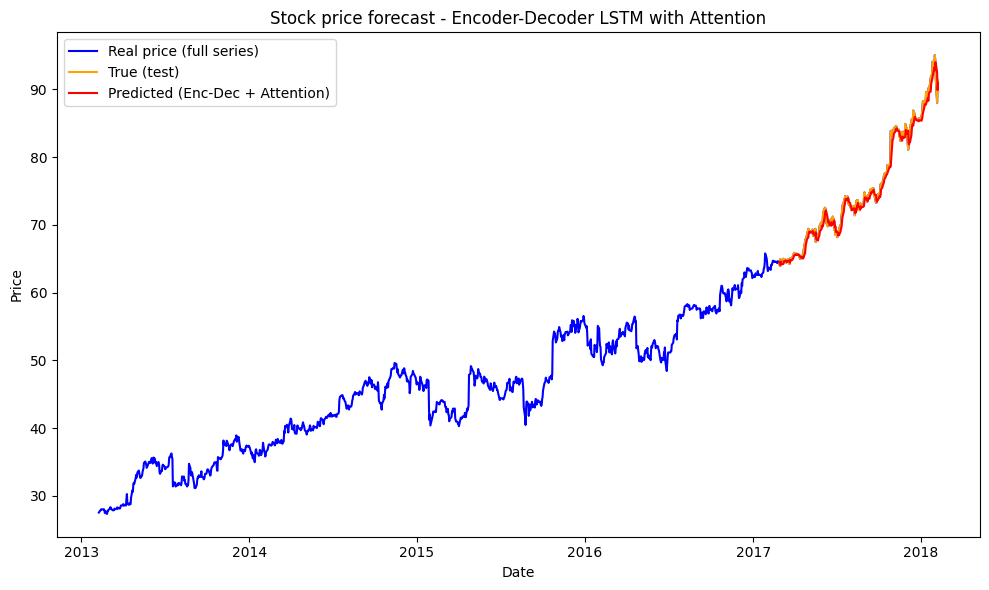

In [80]:
# =========================================
# 10. Plot results
# =========================================
plt.figure(figsize=(10, 6))

# Full original series (blue)
plt.plot(data.index, data['close'], label='Real price (full series)', color='blue')

# True test prices (orange)
plt.plot(test_index, true_prices[:, 0], label='True (test)', color='orange')

# Predicted prices (red)
plt.plot(test_index, pred_prices[:, 0], label='Predicted (Enc-Dec + Attention)', color='red')

plt.title("Stock price forecast - Encoder-Decoder LSTM with Attention")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Best MLP

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [83]:
# ==========================================================
#  11. MLP (8 neurons, 200 epochs) with 15 log-return inputs
# ==========================================================

# 1) Map OHLCV names (handle upper/lower case)
col_variants = {
    "Close": ["Close", "close"],
    "Open":  ["Open", "open"],
    "High":  ["High", "high"],
    "Low":   ["Low", "low"],
    "Volume":["Volume", "volume"]
}
col_map = {}
for k, lst in col_variants.items():
    for c in lst:
        if c in df.columns:
            col_map[k] = c
            break

ohlcv = df[[col_map["Close"], col_map["Open"], col_map["High"],col_map["Low"], col_map["Volume"]]].astype("float64")
ohlcv.columns = ["Close", "Open", "High", "Low", "Volume"]

close_series = ohlcv["Close"]

# 2) Compute log-returns
log_ret = np.log(ohlcv / ohlcv.shift(1))

# 3) Build 15 inputs: 5 vars × 3 lags
lags = [1, 2, 3]
X_features = pd.DataFrame(index=log_ret.index)
feature_cols = []

for col in ["Close", "Open", "High", "Low", "Volume"]:
    for L in lags:
        name = f"{col}_lag{L}"
        X_features[name] = log_ret[col].shift(L)
        feature_cols.append(name)

# Target: log-return of Close(t+1)
y_target = log_ret["Close"].shift(-1)

# Drop rows with missing values
data_mlp = pd.concat([X_features, y_target], axis=1).dropna()
X = data_mlp[feature_cols]
y = data_mlp["Close"]

# 4) Train/test split using test_index (dates)
X_test = X.loc[X.index.isin(test_index)]
y_test = y.loc[y.index.isin(test_index)]
X_train = X.loc[~X.index.isin(test_index)]
y_train = y.loc[~y.index.isin(test_index)]

# 5) Standardize inputs
scaler_X = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

# 6) Define the MLP model
model = MLPRegressor(
    hidden_layer_sizes=(8,),
    activation="logistic",
    solver="sgd",
    learning_rate_init=0.01,
    momentum=0.9,
    batch_size=32,
    max_iter=200,
    shuffle=True,
    n_iter_no_change=201,
    tol=0.0,
    random_state=3407
)

# 7) Train the model
model.fit(X_train_s, y_train.values)

# 8) Predict log-return on test set
yhat_ret_test = model.predict(X_test_s)

# 9) Convert log-return predictions back to price forecasts
prev_close_test = close_series.reindex(X_test.index)
y_pred_price = prev_close_test * np.exp(yhat_ret_test)

# True next-day prices
y_true_price = close_series.shift(-1).reindex(X_test.index)

# Remove missing values
valid = (~y_true_price.isna()) & (~y_pred_price.isna())
y_pred_price = y_pred_price[valid]
y_true_price = y_true_price[valid]
test_idx = y_true_price.index

# 10) Compute MAE
mae_mlp = np.mean(np.abs(y_true_price.values - y_pred_price.values))
print(f"Test MAE MLP (8 neurons, 200 epochs): {mae_mlp:.6f}")

Test MAE MLP (8 neurons, 200 epochs): 0.613138


C:\Users\Manuel\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


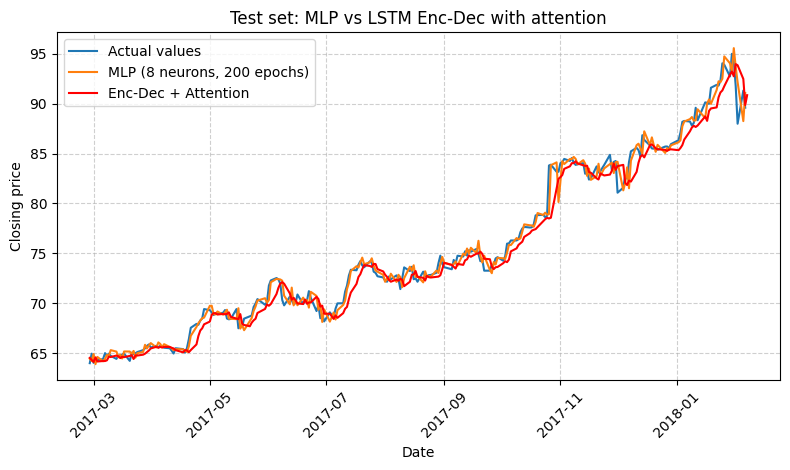

In [92]:
# 11) Plot result on full test set
plt.figure(figsize=(8, 4.8))
plt.plot(test_idx, y_true_price, label="Actual values")
plt.plot(test_idx, y_pred_price, label="MLP (8 neurons, 200 epochs)")
plt.plot(test_index, pred_prices[:, 0], label='Enc-Dec + Attention', color='red')

plt.title("Test set: MLP vs LSTM Enc-Dec with attention")
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("EncDec.png", dpi=300, bbox_inches='tight')
plt.show()